In [1]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # For GPU

In [27]:
import keras
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
model = keras.models.load_model("model128x128_from_whole/unet_model_upsampling_128x128_from_whole.hdf5")

In [5]:
data_path = "../../data/Brats2018/"
#data_path = "/mnt/data/medical/brats/Brats2018/"

#imgs128x128 = np.load(os.path.join(data_path, "128x128/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
#msks128x128 = np.sum(np.load(os.path.join(data_path, "128x128/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)

#imgs240x240 = np.load(os.path.join(data_path, "240x240/imgs_test.npy"), mmap_mode="r", allow_pickle=False)
#msks240x240 = np.sum(np.load(os.path.join(data_path, "240x240/msks_test.npy"), mmap_mode="r", allow_pickle=False), axis=-1)

import h5py 

hdfFile = h5py.File(os.path.join(data_path, "240x240/processed_data.hdf5"), "r")
imgs240x240 = hdfFile["images/test"]
msks240x240 = hdfFile["masks/test"]

In [6]:
# Predict based on center crop of 128x128
pred128x128 = model.predict(np.expand_dims(imgs240x240[:,56:184,56:184,2], -1), verbose=1)

8215/8215 [==============================] - 181s 22ms/step


In [7]:
pred240x240 = model.predict(np.expand_dims(imgs240x240[:,:,:,2], -1), verbose=1)

8215/8215 [==============================] - 435s 53ms/step


In [ ]:
def dice(msk, pred):
    """
    Dice coefficient
    """
    smooth = 1.0
    
    numerator = 2.0 * np.sum(msk*pred) + smooth
    denominator = np.sum(msk)+np.sum(pred) + smooth 
    
    
    return numerator/denominator

In [123]:
def compare_predictions(img128x128, msk128x128, pred128x128, img240x240, msk240x240, pred240x240):
    
    plt.figure(figsize=(14,14))
    
    plt.subplot2grid((2, 3), (0, 0));
    plt.imshow(img128x128, cmap="bone")
    plt.title("MRI 128x128 (crop)", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.subplot2grid((2, 3), (0, 1));
    plt.imshow(msk128x128)
    plt.title("Mask 128x128 (crop)", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.subplot2grid((2, 3), (0, 2));
    plt.imshow(pred128x128)
    plt.title("Prediction 128x128 (crop)", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    
    print("Dice cropped = {:.2f}".format(dice(msk128x128, pred128x128)))
    
    plt.subplot2grid((2, 3), (1, 0));
    plt.imshow(img240x240, cmap="bone")
    plt.title("MRI 240x240", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.subplot2grid((2, 3), (1, 1));
    plt.imshow(msk240x240)
    plt.title("Mask 240x240", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.subplot2grid((2, 3), (1, 2));
    plt.imshow(pred240x240)
    plt.title("Prediction 240x240", fontsize=18)
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    
    # Reduce space between rows
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.4)
    
    print("Dice full image = {:.2f}".format(dice(msk240x240, pred240x240)))

In [109]:
dice_scores_full = np.zeros(msks240x240.shape[0])
volume = np.zeros(msks240x240.shape[0])
dice_scores_crop = np.zeros(msks240x240.shape[0])

for idx in tqdm(range(msks240x240.shape[0])):
    volume[idx] = np.sum(msks240x240[idx,:,:,:])
    dice_scores_full[idx] = dice(np.sum(msks240x240[idx,:,:,:],axis=2), pred240x240[idx,:,:,0])
    dice_scores_crop[idx] = dice(np.sum(msks240x240[idx,56:184,56:184,:], axis=2), pred128x128[idx,:,:,0])
    

  2%|▏         | 170/8215 [00:05<04:39, 28.77it/s]


KeyboardInterrupt: 

In [43]:
good_idx = np.intersect1d(np.where(volume > 100)[0], np.where((dice_scores_full - dice_scores_crop) > 0.2)[0])
good_idx.shape

(25,)

In [73]:
good_idx[23]

8137

Dice cropped = 0.69
Dice full image = 0.90


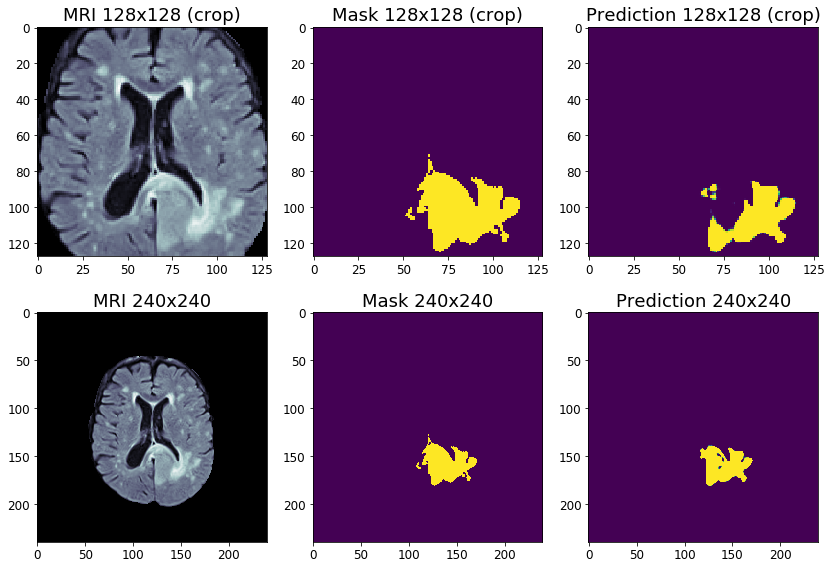

In [124]:
idx = good_idx[9]   #idx 3804, 8137

compare_predictions(imgs240x240[idx,56:184,56:184,2], np.sum(msks240x240[idx,56:184,56:184,:], axis=2), pred128x128[idx,:,:,0], 
                    imgs240x240[idx,:,:,2], np.sum(msks240x240[idx,:,:,:],axis=2), pred240x240[idx,:,:,0])
